# Kiva Crowdfunding

*Kiva.org is an online crowdfunding platform to extend financial services to poor and financially excluded people around the world. Kiva lenders have provided over $1 billion dollars in loans to over 2 million people. In order to set investment priorities, help inform lenders, and understand their target communities, knowing the level of poverty of each borrower is critical. However, this requires inference based on a limited set of information for each borrower.*

## Prediction and Models

* Not all loan requests are funded (about 3383 records in loans dataset that are not funded). Is there a pattern among the loans not funded?  

* Group Loans into Clusters and identify Top Features [Unsupervised Learning]. 

* Predict if a loan request is likely to get funded or not [Logistic Regression] 


In [125]:
%matplotlib inline

# General libraries.
import re
import math
import numpy as np
import collections
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
from mpl_toolkits.basemap import Basemap
color = sns.color_palette()
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.offline as py
from sklearn import datasets
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn import cluster, mixture # For clustering 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_samples, silhouette_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import feature_selection
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

# For producing decision tree diagrams.
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO
import pydot
import graphviz

import warnings
warnings.filterwarnings('ignore')

## EDA - LOOK AT THE OTHER FILE. THIS ONE IS JUST MODELS

### Kiva Loans

In [2]:
df_kiva_loans = pd.read_csv("kiva_loans.csv")
df_kiva_loans.head()
#df_kiva_loans.describe(include = 'all')

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,11.0,8,NaN,female,irregular,2014-01-01
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,245.0,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,14.0,16,NaN,female,monthly,2014-01-01


In [3]:
df_kiva_loans['borrower_genders'].value_counts()

female                                                                                                                                                                                                                                                      426502
male                                                                                                                                                                                                                                                        134710
female, female                                                                                                                                                                                                                                               12164
female, female, female                                                                                                                                                                                                         

In [4]:
df_kiva_loans.describe()

,id,funded_amount,loan_amount,partner_id,term_in_months,lender_count
count,6.712050e+05,671205.000000,671205.000000,657698.000000,671205.000000,671205.000000
mean,9.932486e+05,785.995061,842.397107,178.199616,13.739022,20.590922
std,1.966113e+05,1130.398941,1198.660073,94.247581,8.598919,28.459551
min,6.530470e+05,0.000000,25.000000,9.000000,1.000000,0.000000
25%,8.230720e+05,250.000000,275.000000,126.000000,8.000000,7.000000
50%,9.927800e+05,450.000000,500.000000,145.000000,13.000000,13.000000
75%,1.163653e+06,900.000000,1000.000000,204.000000,14.000000,24.000000
max,1.340339e+06,100000.000000,100000.000000,536.000000,158.000000,2986.000000


** OBSERVATION: Funded Amount, Loan Amount and Lender Count are highly correlated**


In [5]:
# Identify rows with no funding (Funding amount = 0)
df_nofund = df_kiva_loans[(df_kiva_loans['funded_amount']==0)]
df_nofund.shape

(3383, 20)


 **OBSERVATION: There are about 3383 rows with funded amount = 0**  <font size="4">$\color{red}{\text{Is there any pattern among loans that are not funded?}}$ </font>


**OBSERVATION: Philippines, Kenya and El Salvador are the top 3 countries featuring in Loans dataset.  United States, Kenya and Pakistan are the countries top countries with loan amount not funded**

**OBSERVATION: Agriculture, Food and Retail are the top 3 sectors based on Loan Amount.  And these are the top 3 that are not getting funds **

** OBSERVATION: Farming is the top activity based on Loan Amount, followed by General Store and Personal Housing Expenses**

** OBSERVATION: There are more Female borrowers than male **

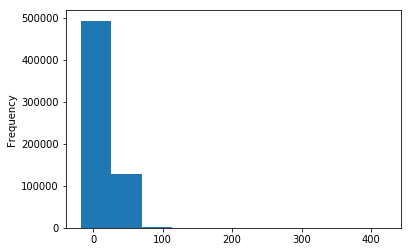

In [6]:
# Determine Time Taken for Funding. It is Loan Posted Time - Funded Time

df_funded = df_kiva_loans[(df_kiva_loans['funded_amount']!=0)]
df_funded.dropna()
df_funded.shape

df_funded['funded_time'] = pd.to_datetime(df_funded['funded_time'])
df_funded['posted_time'] = pd.to_datetime(df_funded['posted_time'])    
time_to_fund = (df_funded.funded_time - df_funded.posted_time)
time_to_fund_in_days = (time_to_fund.astype('timedelta64[s]')/(3600 * 24))
df_funded = df_funded.assign(time_to_fund=time_to_fund)
df_funded = df_funded.assign(time_to_fund_in_days=time_to_fund_in_days)
df_funded.time_to_fund_in_days.plot.hist();

In [7]:
countries_funded_amount = df_kiva_loans.groupby('country').mean()['funded_amount'].sort_values(ascending = False)
print("Top Countries with funded amount (Mean values)\n",countries_funded_amount.head(10))

Top Countries with funded amount (Mean values)
 country
Cote D'Ivoire         50000.000000
Mauritania            15000.000000
Bhutan                 7812.500000
Chile                  7625.000000
Afghanistan            7000.000000
Congo                  6142.578125
Puerto Rico            4409.191176
Dominican Republic     4200.604839
Namibia                4046.875000
United States          3800.843591
Name: funded_amount, dtype: float64


**OBSERVATION: Cote D'Ivoire, Mauritania, Bhutan got top funding**   

In [8]:
df_funded
funded_time = df_funded.groupby('country').mean()['time_to_fund_in_days'].sort_values(ascending = False)
print("Top Countries with max funded_time(Mean values)\n",funded_time.head(10))

Top Countries with max funded_time(Mean values)
 country
United States    39.544380
Puerto Rico      38.112630
Vanuatu          35.963452
El Salvador      22.054165
Azerbaijan       21.930762
Bolivia          21.458772
Georgia          20.976522
Armenia          20.607393
Colombia         20.366121
Kenya            20.161696
Name: time_to_fund_in_days, dtype: float64


**OBSERVATION: US, Puerto Rico, Vanuata take longer time for funding**

### MPI Region/Location

** OBSERVATION: As expected, Africa has the HIGHEST Poverty followed by South Asia **

# Models

## Model Selection

- Scaling and normalizing the data
- Dividing the data into a training and testing sets
- Evaluating an initial model
- Selecting the columns with the highest weights
- Creating the final model
- Measuring the model's performance

## Pre-processing & Splitting

In [10]:
use_col = ['funded_amount', 'loan_amount', 'sector', 'country', 'term_in_months', 'lender_count', 'borrower_genders', 'repayment_interval']
df_loans = df_kiva_loans[use_col].copy()
df_loans.head()

,funded_amount,loan_amount,sector,country,term_in_months,lender_count,borrower_genders,repayment_interval
0,300.0,300.0,Food,Pakistan,12.0,12,female,irregular
1,575.0,575.0,Transportation,Pakistan,11.0,14,"female, female",irregular
2,150.0,150.0,Transportation,India,43.0,6,female,bullet
3,200.0,200.0,Arts,Pakistan,11.0,8,female,irregular
4,400.0,400.0,Food,Pakistan,14.0,16,female,monthly


In [11]:
df_loans['sector'].value_counts()

Agriculture       180302
Food              136657
Retail            124494
Services           45140
Personal Use       36385
Housing            33731
Clothing           32742
Education          31013
Transportation     15518
Arts               12060
Health              9223
Construction        6268
Manufacturing       6208
Entertainment        830
Wholesale            634
Name: sector, dtype: int64

In [12]:
df_loans.isnull().sum()

funded_amount            0
loan_amount              0
sector                   0
country                  0
term_in_months           0
lender_count             0
borrower_genders      4221
repayment_interval       0
dtype: int64

In [13]:
df_loans.dropna(inplace=True)

In [14]:
df_loans.shape

(666984, 8)

In [15]:
df_loans['percent_female'] = df_loans['borrower_genders'].apply(lambda x: np.mean(np.array(x.split(',')) == 'female'))
df_loans['applicants'] = df_loans['borrower_genders'].apply(lambda x: len(x.split(',')))
df_loans.drop('borrower_genders', axis=1, inplace=True)

In [16]:
df_loans.head()

,funded_amount,loan_amount,sector,country,term_in_months,lender_count,repayment_interval,percent_female,applicants
0,300.0,300.0,Food,Pakistan,12.0,12,irregular,1.0,1
1,575.0,575.0,Transportation,Pakistan,11.0,14,irregular,0.5,2
2,150.0,150.0,Transportation,India,43.0,6,bullet,1.0,1
3,200.0,200.0,Arts,Pakistan,11.0,8,irregular,1.0,1
4,400.0,400.0,Food,Pakistan,14.0,16,monthly,1.0,1


In [17]:
df_loans['granted'] = 1*(df_loans['loan_amount'] == df_loans['funded_amount'])
df_loans.drop('funded_amount', axis=1, inplace=True)

In [18]:
df_loans['granted'].value_counts()

1    619336
0     47648
Name: granted, dtype: int64

In [19]:
47648/(47648+619336)*100

7.143799551413527

In [20]:
df_loans.head()

,loan_amount,sector,country,term_in_months,lender_count,repayment_interval,percent_female,applicants,granted
0,300.0,Food,Pakistan,12.0,12,irregular,1.0,1,1
1,575.0,Transportation,Pakistan,11.0,14,irregular,0.5,2,1
2,150.0,Transportation,India,43.0,6,bullet,1.0,1,1
3,200.0,Arts,Pakistan,11.0,8,irregular,1.0,1,1
4,400.0,Food,Pakistan,14.0,16,monthly,1.0,1,1


In [21]:
df_loans.shape

(666984, 9)

In [22]:
df_loans = pd.concat((df_loans,pd.get_dummies(df_loans[['sector', 'country', 'repayment_interval']], drop_first=True)), axis=1)
df_loans.drop(['sector', 'country', 'repayment_interval'], axis=1, inplace=True)
df_loans.shape
df_loans.head()

df_loans1 = df_loans.copy()
features = df_loans.drop('granted', axis=1).columns

In [23]:
X = df_loans.drop('granted', axis=1).values
y = df_loans['granted'].values
print(X.shape)
print(y.shape)


(666984, 108)
(666984,)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Random Forest

In [31]:
rfc = RandomForestClassifier(n_estimators=50)
rfc.fit(X_train, y_train)
#rfc.score(X_test, y_test)
score = rfc.score(X_test, y_test)
print("Score from Random Forest is %.2f%%" %(score*100))

Score from Random Forest is 96.00%


In [26]:
y_pred = rfc.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
print ('True Positive=', tp)
print ('False Positive=', fp)
print ('True Negative=', tn)
print ('False Negative=', fn)

True Positive= 201221
False Positive= 5790
True Negative= 10009
False Negative= 3085


In [27]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.76      0.63      0.69     15799
          1       0.97      0.98      0.98    204306

avg / total       0.96      0.96      0.96    220105



In [28]:
print ("Accuracy is ", (tp+tn) / (tp+fn+fp+tn))

Accuracy is  0.9596783353399514


### Feature Importance from Random Forest

In [71]:
importances = pd.DataFrame({"Feature": features, 'Score': rfc.feature_importances_})
importances = importances.sort_values(by='Score', ascending=False).head(10)

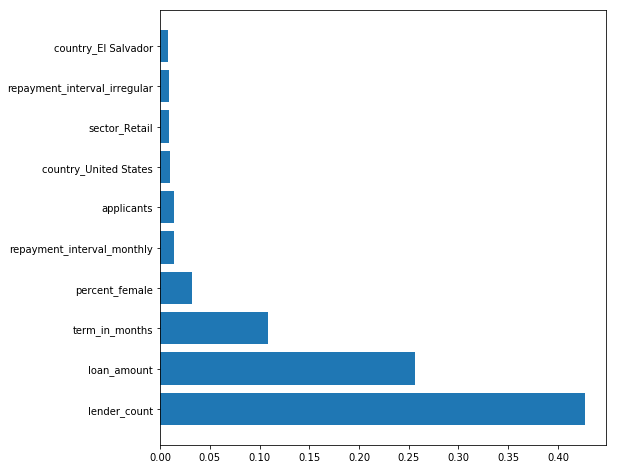

In [72]:
plt.figure(figsize=(8,8))
plt.barh(range(10), importances['Score'])
a = plt.yticks(range(10), importances['Feature'])

##  Decision Tree

In [93]:
clf = DecisionTreeClassifier(criterion = "entropy", random_state = 100,
                               max_depth=3, min_samples_leaf=5, min_samples_split=10)
clf.fit(X_train, y_train)

print ('Accuracy:', clf.score(X_test, y_test))


Accuracy: 0.9396379000931374


In [94]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.60      0.48      0.53     15799
          1       0.96      0.98      0.97    204306

avg / total       0.93      0.94      0.94    220105



In [95]:

tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
print ('True Positive=', tp)
print ('False Positive=', fp)
print ('True Negative=', tn)
print ('False Negative=', fn)

True Positive= 199297
False Positive= 8277
True Negative= 7522
False Negative= 5009


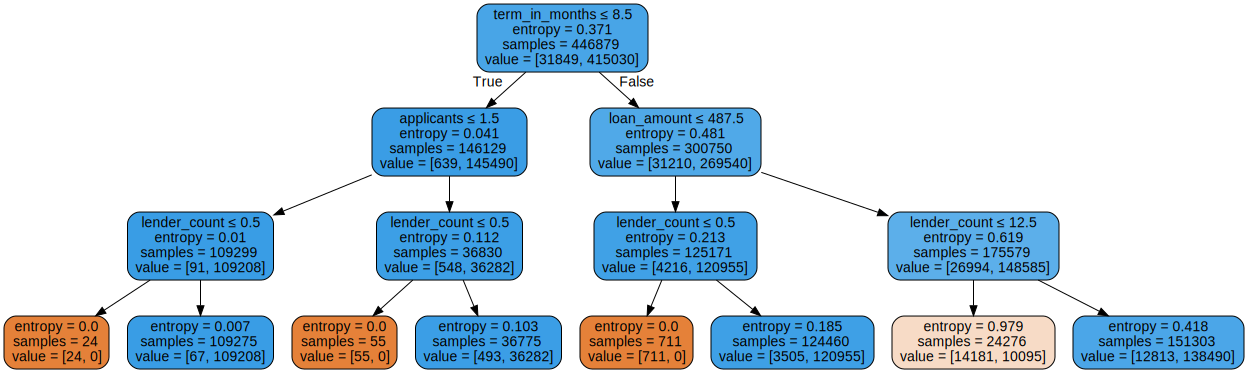

In [64]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=features,  
                      #class_names=y_test,  
                      filled=True, rounded=True,  
                      special_characters=True)


graph = graphviz.Source(dot_data)  
graph 

Label distribution [0.07126985 0.92873015 0.         ... 0.         0.         0.        ]
Label entropy: 0.37064471920610637
Uniform entropy: 1.584962500721156
nan loan_amount
nan term_in_months
nan lender_count
nan percent_female
nan applicants
nan sector_Arts
nan sector_Clothing
nan sector_Construction
nan sector_Education
nan sector_Entertainment
nan sector_Food


KeyboardInterrupt: 

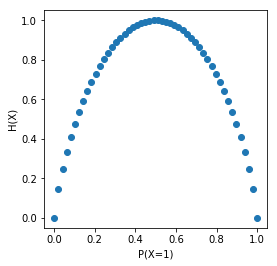

In [84]:
# A function that computes information gain given these inputs:
#   data: an array of featurized examples
#   labels: an array of labels corresponding to the the data
#   feature: the feature to use to split the data
#   threshold: the feature value to use to split the data (the default threshold is good for binary features)

def entropy(distribution):
    h = 0.0
    for probability in distribution:
        logprob = -100.0  # log(0) = -inf so let's approximate it with -100 to avoid an error
        if probability > 0.0: logprob = np.log2(probability)
        h -= probability * logprob
    return h

# Show a plot of the entropy, H(X), of a Bernoulli random variable X.
p_values = np.linspace(0, 1, 50)
entropies = [entropy([p, 1-p]) for p in p_values]
plt.figure(figsize=(4,4))
plt.plot(p_values, entropies, 'o')
plt.xlabel('P(X=1)')
plt.ylabel('H(X)')



def get_label_distribution(labels):
    # Initialize counters for all labels to zero.
    label_probs = np.array([0.0 for i in range(len(y_train))])

    # Iterate over labels in the training data and update counts.
    for label in labels:
        label_probs[label] += 1.0
    
    # Normalize to get a distribution.
    label_probs /= label_probs.sum()
    return label_probs

label_probs = get_label_distribution(y_train)
print ('Label distribution', label_probs)

# Compare the label entropy to a uniform distribution.
print ('Label entropy:', entropy(label_probs))
print ('Uniform entropy:', entropy([1./3, 1./3, 1./3]))


def information_gain(data, labels, feature, threshold=0):
    # Get the initial entropy of the label distribution.
    initial_entropy = entropy(get_label_distribution(labels))
    
    # subset0 will contain the labels for which the feature is 0 and
    # subset1 will contain the labels for which the feature is 1.
    subset0, subset1 = [], []
    for datum, label in zip(data, labels):
        if datum[feature] > threshold: subset1.append(label)
        else: subset0.append(label)
    
    # Compute the entropy of each subset.
    subset0_entropy = entropy(get_label_distribution(subset0))
    subset1_entropy = entropy(get_label_distribution(subset1))
    
    # Compute the final entropy by weighting each subset's entropy according to its size.
    subset0_weight = 1.0 * len(subset0) / len(labels)
    subset1_weight = 1.0 * len(subset1) / len(labels)
    final_entropy = subset0_weight * subset0_entropy + subset1_weight * subset1_entropy
    
    # Finally, compute information gain as the difference between the initial and final entropy.
    return initial_entropy - final_entropy

#infogain = pd.DataFrame(data= features)
#infogain['ig_val'] = 0 
for i in range(X_train.shape[1]):
    infogain['ig_val'] = information_gain(X_train, y_train, i)
    print ('%.3f %s' %(ig, features[i]))
     
#infogain.head()


    

## XGBoost

In [96]:
from xgboost import XGBClassifier
clf_xgb = XGBClassifier()
clf_xgb.fit(X_train, y_train)
y_pred = clf_xgb.predict(X_test)
print(classification_report(y_test, y_pred))

print ('Accuracy:', clf_xgb.score(X_test, y_test))

             precision    recall  f1-score   support

          0       0.83      0.53      0.65     15799
          1       0.96      0.99      0.98    204306

avg / total       0.95      0.96      0.95    220105

Accuracy: 0.9584516480770542


In [89]:
y_pred = clf_xgb.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
print ('True Positive=', tp)
print ('False Positive=', fp)
print ('True Negative=', tn)
print ('False Negative=', fn)

True Positive= 202588
False Positive= 7427
True Negative= 8372
False Negative= 1718


In [113]:
imp = pd.DataFrame({"Feature": features, "Score": clf_xgb.feature_importances_ })
imp = imp.sort_values(by = 'Score', ascending = False).head(10)

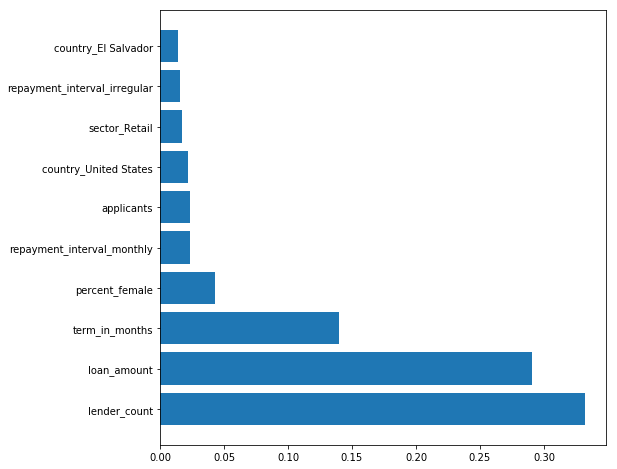

In [114]:
plt.figure(figsize= (8,8))
plt.barh(range(10),imp["Score"])
a = plt.yticks(range(10), importances["Feature"])

## Logistic Regression

In [145]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
y_pred = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
print("Score from Logisitic Regression is %.2f%%" %(score*100))

print(classification_report(y_test, y_pred))

Score from Logisitic Regression is 94.12%
             precision    recall  f1-score   support

          0       0.75      0.27      0.40     15799
          1       0.95      0.99      0.97    204306

avg / total       0.93      0.94      0.93    220105



In [116]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
print ('True Positive=', tp)
print ('False Positive=', fp)
print ('True Negative=', tn)
print ('False Negative=', fn)

True Positive= 202837
False Positive= 11474
True Negative= 4325
False Negative= 1469


In [153]:
top_features = logisticRegr.coef_.argsort(axis=1)[:,-10:].ravel()
for i in top_features:
    print (features[i])

percent_female
country_Haiti
sector_Manufacturing
sector_Arts
sector_Education
repayment_interval_irregular
country_United States
country_Paraguay
country_India
country_Peru


### a. Add "Balanced Class Weight"

In [117]:
lr = LogisticRegression(class_weight="balanced")
lr.fit(X_train, y_train)
predict = lr.predict(X_test)
score1 = lr.score(X_test, y_test)
print("Score from Logisitic Regression with balanced class is %.2f%%" %(score1*100))

Score from Logisitic Regression with balanced class is 85.69%


In [118]:
print(classification_report(y_test, predict))

             precision    recall  f1-score   support

          0       0.31      0.83      0.45     15799
          1       0.98      0.86      0.92    204306

avg / total       0.94      0.86      0.88    220105



In [119]:
confusion_matrix(y_test, predict)
tn, fp, fn, tp = confusion_matrix(y_test, predict, labels=[0,1]).ravel()
print ('Confusion Matrix after adding Class_weight')
print ('True Positive=', tp)
print ('False Positive=', fp)
print ('True Negative=', tn)
print ('False Negative=', fn)

Confusion Matrix after adding Class_weight
True Positive= 175527
False Positive= 2715
True Negative= 13084
False Negative= 28779


### b. Balancced Class weight, L1 Penalty with 0.5 C

In [122]:
lr = LogisticRegression(class_weight="balanced",penalty = 'l2', C=0.5)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
score = lr.score(X_test, y_test)
print("Score from Logisitic Regression is %.2f%%" %(score*100))

print(classification_report(y_test, y_pred))

Score from Logisitic Regression is 85.70%
             precision    recall  f1-score   support

          0       0.31      0.83      0.45     15799
          1       0.98      0.86      0.92    204306

avg / total       0.94      0.86      0.88    220105



In [123]:
confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
print ('Confusion Matrix after adding Class_weight')
print ('True Positive=', tp)
print ('False Positive=', fp)
print ('True Negative=', tn)
print ('False Negative=', fn)

Confusion Matrix after adding Class_weight
True Positive= 175565
False Positive= 2728
True Negative= 13071
False Negative= 28741


### Grid Search with different C

In [129]:
lgr = LogisticRegression(penalty = 'l2', C=0.5)
lgr.fit(X_train,y_train)
 
cval = {'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 20.0, 30.0, 50.0, 100.0]}
grid = GridSearchCV(estimator=lgr, param_grid=cval, cv=5,scoring='f1_weighted' )
grid.fit(X_train, y_train)
print('The best value for C', grid.best_params_)
print('The best score',grid.best_score_)

The best value for C {'C': 1.0}
The best score 0.9304005451939457


In [130]:
lgr = LogisticRegression(class_weight="balanced", penalty = 'l2', C=1.0)
lgr.fit(X_train,y_train)
predict = lr.predict(X_test)
score1 = lr.score(X_test, y_test)
print("Score from Logisitic Regression with balanced class is %.2f%%" %(score1*100))

print(classification_report(y_test, predict))

Score from Logisitic Regression with balanced class is 85.70%
             precision    recall  f1-score   support

          0       0.31      0.83      0.45     15799
          1       0.98      0.86      0.92    204306

avg / total       0.94      0.86      0.88    220105



In [131]:
confusion_matrix(y_test, predict)
tn, fp, fn, tp = confusion_matrix(y_test, predict, labels=[0,1]).ravel()
print ('Confusion Matrix after adding Class_weight')
print ('True Positive=', tp)
print ('False Positive=', fp)
print ('True Negative=', tn)
print ('False Negative=', fn)

Confusion Matrix after adding Class_weight
True Positive= 175565
False Positive= 2728
True Negative= 13071
False Negative= 28741


### b. Grid Search and Parameter Tuning

Best parameters : {'class_weight': {0: 0.618421052631579, 1: 0.381578947368421}}


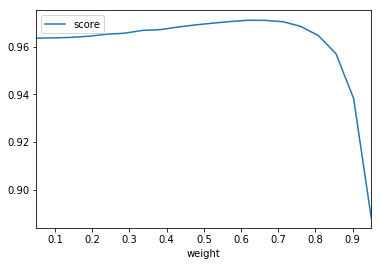

In [132]:


weights = np.linspace(0.05, 0.95, 20)

gsc = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=3
)
grid_result = gsc.fit(X_train, y_train)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

In [133]:
logreg = LogisticRegression(**grid_result.best_params_)

# Fit..
logreg.fit(X_train, y_train)

# Predict..
y_pred = logreg.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
#plot_confusion_matrix(confusion_matrix(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.71      0.39      0.50     15799
          1       0.95      0.99      0.97    204306

avg / total       0.94      0.94      0.94    220105



In [138]:
confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
print ('Confusion Matrix after adding Class_weight')
print ('True Positive=', tp)
print ('False Positive=', fp)
print ('True Negative=', tn)
print ('False Negative=', fn)

Confusion Matrix after adding Class_weight
True Positive= 201808
False Positive= 9639
True Negative= 6160
False Negative= 2498


### c.  UnderSampling

In [139]:
# Separate majority and minority classes
from sklearn.utils import resample
df_majority = df_loans1[df_loans1.granted == 1]
df_minority = df_loans1[df_loans1.granted == 0]
df_minority.shape

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=47648,     # to match minority class
                                 random_state=123) # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.granted.value_counts()

1    47648
0    47648
Name: granted, dtype: int64

In [141]:
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    df_downsampled.drop('granted', axis=1).values, df_downsampled['granted'].values, 
                 test_size=0.33, random_state=42)

In [142]:
# Separate input features (X) and target variable (y)

# Train model
clf_2 = LogisticRegression().fit(X_train_balanced, y_train_balanced)
 
# Predict on training set
y_pred = clf_2.predict(X_test_balanced)

 
# accuracy
print(classification_report(y_test_balanced, y_pred))



             precision    recall  f1-score   support

          0       0.86      0.84      0.85     15693
          1       0.84      0.86      0.85     15755

avg / total       0.85      0.85      0.85     31448



### Revisit Random Forest

In [144]:
rfc = RandomForestClassifier(n_estimators=50)
rfc.fit(X_train_balanced, y_train_balanced)
y_pred = rfc.predict(X_test_balanced)
print(classification_report(y_test_balanced, y_pred))

             precision    recall  f1-score   support

          0       0.90      0.91      0.90     15693
          1       0.91      0.90      0.90     15755

avg / total       0.90      0.90      0.90     31448



## SelectKBest

In [135]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# feature extraction
test = SelectKBest(score_func=chi2, k=10)
fit = test.fit(X_train, y_train)
# summarize scores
np.set_printoptions(precision=3)

sorted_features = features[fit.scores_.argsort()]
for i, x in enumerate(features[fit.scores_.argsort()].tolist()[::-1][:10]):
    print(i, x)


#features = fit.transform(X_train)
# summarize selected features
#print(features[0:5,:])

0 country_Mauritania
1 country_Cote D'Ivoire
2 loan_amount
3 term_in_months
4 lender_count
5 repayment_interval_irregular
6 country_United States
7 country_Philippines
8 country_El Salvador
9 country_Colombia


## PCA and Kmeans Clustering

In [ ]:
def apply_pca():
    pca = PCA(n_components=2)
    train_data_comp = pca.fit_transform(X_train)
    test_data_comp = pca.transform(X_test)
   
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
   
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 Component PCA', fontsize = 20)
    c= np.where(y_train==0,'r','b')
    ax.scatter(train_data_comp[:,0], train_data_comp[:,1], c=c)
    
    return pca

pca = apply_pca()


In [ ]:
 
pca = PCA(n_components=10)
train_data_comp = pca.fit_transform(X_train)
test_data_comp = pca.transform(X_test)
trans_data = pca.fit(X_train).transform(X_train)
     
km = KMeans(n_clusters=2, init='k-means++')
clstrs = km.fit(trans_data)
print(km.labels_)

plt.scatter(train_data_comp[:,0], train_data_comp[:,1], c=clstrs.labels_)
plt.plot(clstrs.cluster_centers_[:,0], clstrs.cluster_centers_[:,1], 'ro')  
plt.show() 



In [ ]:
pca.explained_variance_ratio_.sum()

In [ ]:
## Scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X1 = scaler.transform(X_train)

## PCA projection to 2D
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X1)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])


In [ ]:
principalDf.head()
#finalDf = pd.concat([principalDf, df[['target']]], axis = 1)

In [154]:
clf_pos = GMM(n_components=4, covariance_type='full')
clf_pos.fit(train_data_comp[y_train == 1, :])

clf_neg = GMM(n_components=4, covariance_type='full')
clf_neg.fit(train_data_comp[y_train == 0, :])

prob_pos = clf_pos.score_samples(test_data_comp)
prob_neg = clf_neg.score_samples(test_data_comp)
    
test_class1 = (prob_pos> prob_neg).astype(int)

print ("GMM Accuracy = %.2f%% percent" %(np.mean(test_class1 == y_test)*100))
print(classification_report(y_test, test_class1))

NameError: name 'train_data_comp' is not defined